In [1]:
import warnings
import json
import argparse
from itertools import chain
from functools import partial
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
from transformers import AutoTokenizer, Trainer, TrainingArguments
from transformers import AutoModelForTokenClassification, DataCollatorForTokenClassification
from datasets import Dataset, features
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

2025-04-12 21:27:05.362891: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744493225.643761      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744493225.724338      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
models = [
    "google-bert/bert-base-uncased",
    "microsoft/deberta-v3-base",
]

lr = [2e-5, 1e-5, 2e-3]
sl = [386, 512]
frac = [0.6, 1]
bs = [4, 8]
dataset = [1, 2]

In [3]:
class ConfigCreator:
    def __init__(self, model_name=models[1], lr = lr[0], sl = sl[0], frac = frac[0], bs = bs[0], dataset = dataset[0]):
        self.model_name = model_name
        self.lr = lr
        self.sl = sl
        self.frac = frac
        self.bs = bs
        self.dataset = dataset
    
    def get_config(self):
        class Config:
            MODEL_NAME = self.model_name
            MAX_SEQ_LEN = self.sl
        
            MODEL_SAVE_PATH = f"/kaggle/working/{self.model_name.split('/')[1]}"
            SEED = 42
            FRAC = self.frac
            
            NUM_FOLDS = 3
        
            DATASETS = {
                0: "/kaggle/input/pii-detection-removal-from-educational-data/train.json",
                1: "/kaggle/input/pii-dd-mistral-generated/mixtral-8x7b-v1.json",
            }
            USE_DATASETS = range(self.dataset)
        
            TOKENIZER = AutoTokenizer.from_pretrained(self.model_name)
            LR = self.lr
            WARMUP = 1e-1
            WD = 1e-2
            BS = self.bs
            LOG = 10
            ACC_STEPS = 2
            EPOCHS = 3
        
        return Config

In [4]:
def seed_everything(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

In [5]:
class Preprocessor():
    def __init__(self, config):
        self.config = config
        self.data_paths = [self.config.DATASETS[i] for i in self.config.USE_DATASETS]

    def __build_text_and_labels(self, example, target):
        """
        Rebuild the text and align the labels based on tokens, provided labels, and whitespace information.
    
        Args:
            example (dict): The input example containing tokens, labels, and whitespace information.
    
        Returns:
            tuple: A tuple (text, aligned_labels), where text is the rebuilt text and aligned_labels is the list of corresponding labels.
        """
        text = []
        aligned_labels = []
        targets = []

        for token, label, has_whitespace in zip(example["tokens"], example["given_labels"], example["trailing_whitespace"]):
            text.append(token)
            aligned_labels.extend([label] * len(token))
    
            if label in target:
                targets.append(1)
            else:
                targets.append(0)
    
            if has_whitespace:
                text.append(" ")
                aligned_labels.append("O")
    
        return "".join(text), np.array(aligned_labels), targets

    def __tokenize_text(self, text, max_seq_len, truncation=True):
        """
        Tokenize the full text using the tokenizer and return tokenized output.
    
        Args:
            text (str): The text to tokenize.
            tokenizer (object): The tokenizer to use for tokenization.
            max_seq_len (int): The maximum length for the tokenized sequence.
    
        Returns:
            dict: The tokenized output containing input_ids, attention_mask, and offset_mapping.
        """
        return self.config.TOKENIZER(text, return_offsets_mapping=True, truncation=truncation, max_length=max_seq_len)
    
    def __adjust_start_index(self, start_idx, text):
        """
        Adjust the starting index if the token starts with whitespace.
    
        Args:
            start_idx (int): The start index of the token.
            text (str): The full text to check for whitespace.
    
        Returns:
            int: The adjusted start index.
        """
        if text[start_idx].isspace():
            return start_idx + 1
        return start_idx
    
    def __align_labels_to_tokens(self, offset_mapping, text, aligned_labels, ltoi):
        """
        Align the labels to the tokenized tokens using offset mapping.
    
        Args:
            offset_mapping (list): The list of token offsets.
            text (str): The full original text.
            aligned_labels (numpy array): The aligned labels for the original tokens.
            label2id (dict): A dictionary mapping label names to IDs.
    
        Returns:
            list: A list of token-level labels.
        """
        tokenized_labels = []
    
        for start, end in offset_mapping:
            # Handle special tokens (like [CLS] token)
            if start == 0 and end == 0:
                tokenized_labels.append(ltoi["O"])
                continue
    
            start_idx = self.__adjust_start_index(start, text)
            tokenized_labels.append(ltoi[aligned_labels[start_idx]])
    
        return tokenized_labels

    def __load_data(self, paths):
        df_list = [pd.read_json(path) for path in paths]
        df = pd.concat(df_list, ignore_index=True)
        print(f"Loaded {df.shape[0]} rows and {df.shape[1]} columns")
        print("Preprocessing Data..")

        # positive samples
        df["postive_samples"] = df["labels"].apply(lambda row: any((label[:2] == "B-" or label[:2] == "I-") for label in row))

        # negative samples
        negative_samples = df[~df["postive_samples"]].sample(frac=self.config.FRAC, random_state=self.config.SEED)

        new_df = pd.concat([df[df["postive_samples"]], negative_samples], ignore_index=True)

        # drop column used for filtering out positive samples
        new_df.drop(columns=["postive_samples"], inplace=True)

        df_json = new_df.to_json(orient="records")

        data = json.loads(df_json)

        return data
    
    def _preprocess_example(self, example, ltoi, max_seq_len, targets):
        """
        Preprocess an example by tokenizing the text and assigning the corresponding labels.
    
        Args:
            example (dict): The input example containing tokens, labels, and whitespace information.
            tokenizer (object): The tokenizer used to convert text into token IDs.
            label2id (dict): A dictionary mapping label names to IDs.
            max_seq_len (int): The maximum length of the tokenized sequence.
    
        Returns:
            dict: A dictionary containing the tokenized inputs, labels, and sequence length.
        """
        # Step 1: Rebuild text and labels
        text, aligned_labels, targets = self.__build_text_and_labels(example, targets)
    
        # Step 2: Tokenize the text
        tokenized_output = self.__tokenize_text(text, max_seq_len)
    
        # Step 3: Align token-level labels
        tokenized_labels = self.__align_labels_to_tokens(tokenized_output["offset_mapping"], text, aligned_labels, ltoi)
    
        # Step 4: Return the final tokenized output with labels and sequence length
        sequence_length = len(tokenized_output["input_ids"])
    
        return {
            **tokenized_output, 
            "labels": tokenized_labels, 
            "length": sequence_length, 
            "group": 1 if sum(targets) > 0 else 0
        }

    def get_dataset(self):
        data = self.__load_data(self.data_paths)
        
        dataset = Dataset.from_dict({
            "full_text": [x["full_text"] for x in data],
            "document": [str(x["document"]) for x in data],
            "tokens": [x["tokens"] for x in data],
            "trailing_whitespace": [x["trailing_whitespace"] for x in data],
            "given_labels": [x["labels"] for x in data],
        })

        labels = sorted(list(set(chain(*[x["labels"] for x in data]))))
        ltoi = {l: i for i, l in enumerate(labels)}
        itol = {v: k for k, v in ltoi.items()}
        
        targets = ['B-EMAIL', 'B-ID_NUM', 'B-NAME_STUDENT', 'B-PHONE_NUM', 'B-STREET_ADDRESS', 'B-URL_PERSONAL', 'B-USERNAME', 'I-ID_NUM', 'I-NAME_STUDENT', 'I-PHONE_NUM', 'I-STREET_ADDRESS', 'I-URL_PERSONAL']
        
        dataset = dataset.map(self._preprocess_example, fn_kwargs={
            "ltoi": ltoi, 
            "max_seq_len": self.config.MAX_SEQ_LEN, 
            "targets": targets,
        }, num_proc=8)
        
        # Add fold information for cross-validation
        dataset = dataset.add_column("fold", [i % self.config.NUM_FOLDS for i in range(len(dataset))])
        dataset = dataset.class_encode_column("group")

        return {
            "dataset": dataset,
            "labels": labels,
            "ltoi": ltoi,
            "itol": itol,
            "targets": targets,
        }

In [6]:
class ModelTrainer(object):
    def __init__(self, config, fold):
        self.config = config
        self.preprocessor = Preprocessor(self.config)
        self.tokenizer = self.config.TOKENIZER
        
        self.dataset = None
        self.trainer = None
        self.train_dataset = None
        self.eval_dataset = None
        
        # Store metrics for plotting
        self.train_losses = []
        self.eval_losses = []
        self.train_f1_scores = []
        self.eval_f1_scores = []
        self.steps = []

        self.fold = fold

    def load_data(self):
        self.dataset = self.preprocessor.get_dataset()
        
        # Split data based on current fold
        current_fold = self.fold
        self.train_dataset = self.dataset["dataset"].filter(lambda example: example["fold"] != current_fold)
        self.eval_dataset = self.dataset["dataset"].filter(lambda example: example["fold"] == current_fold)
        
        print(f"Train dataset size: {len(self.train_dataset)}")
        print(f"Validation dataset size: {len(self.eval_dataset)}")

    def compute_metrics(self, eval_pred):
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=2)
        
        # Remove padding tokens from evaluation
        true_predictions = []
        true_labels = []
        
        for prediction, label in zip(predictions, labels):
            for i, l in enumerate(label):
                if l != -100:  # -100 is the index used for padding
                    true_predictions.append(prediction[i])
                    true_labels.append(l)
        
        # Convert numeric labels to string labels for better f1 calculation
        true_pred_labels = [self.dataset["itol"][p] for p in true_predictions]
        true_gold_labels = [self.dataset["itol"][l] for l in true_labels]
        
        # Calculate F1 score
        f1 = f1_score(true_gold_labels, true_pred_labels, average="weighted")
        
        return {
            "f1": f1,
        }

    def prep_model(self):
        model = AutoModelForTokenClassification.from_pretrained(
            self.config.MODEL_NAME,
            num_labels=len(self.dataset["labels"]),
            id2label=self.dataset["itol"],
            label2id=self.dataset["ltoi"],
            ignore_mismatched_sizes=True
        )

        collator = DataCollatorForTokenClassification(self.tokenizer, pad_to_multiple_of=16)

        args = TrainingArguments(
            output_dir=f'out_{self.config.MODEL_NAME.split("/")[1]}_fold_{self.fold}', 
            fp16=True,
            learning_rate=self.config.LR,
            num_train_epochs=self.config.EPOCHS,
            per_device_train_batch_size=self.config.BS,
            per_device_eval_batch_size=self.config.BS,
            warmup_ratio=self.config.WARMUP,
            weight_decay=self.config.WD,
            gradient_accumulation_steps=self.config.ACC_STEPS,
            save_total_limit=1,
            logging_steps=self.config.LOG,
            eval_strategy="epoch",     # Changed from "steps" to "epoch"
            load_best_model_at_end=True,
            metric_for_best_model="f1",
            greater_is_better=True,
            report_to="none",
            save_strategy="epoch",           # Changed from "steps" to "epoch"
            seed=self.config.SEED,
        )

        print(f"Training on {args.device}")
        
        self.trainer = Trainer(
            model=model, 
            args=args, 
            train_dataset=self.train_dataset,
            eval_dataset=self.eval_dataset,
            data_collator=collator, 
            tokenizer=self.config.TOKENIZER,
            compute_metrics=self.compute_metrics
        )

    def save(self):
        self.trainer.save_model(f"{self.config.MODEL_SAVE_PATH}_fold_{self.fold}")
        self.tokenizer.save_pretrained(f"{self.config.MODEL_SAVE_PATH}_fold_{self.fold}")

    def run(self):
        self.load_data()
        self.prep_model()
        self.trainer.train()
        
        # Get metrics for plotting
        logs = self.trainer.state.log_history
        
        # Initialize tracking for epoch-specific metrics
        epoch = 0
        epoch_end_steps = []
        
        for log in logs:
            # Track training loss and steps
            if "loss" in log:
                self.train_losses.append(log["loss"])
                self.steps.append(log["step"])
                
            # Track epoch boundaries
            if "epoch" in log and (len(epoch_end_steps) == 0 or log["epoch"] > epoch):
                epoch = log["epoch"]
                epoch_end_steps.append(log["step"])
                
            # Track evaluation metrics
            if "eval_loss" in log:
                self.eval_losses.append(log["eval_loss"])
                if "eval_f1" in log:
                    self.eval_f1_scores.append(log["eval_f1"])
        
        # Calculate final metrics on validation set
        eval_metrics = self.trainer.evaluate()
        print(f"Final validation metrics for fold {self.fold}: {eval_metrics}")
        
        self.save()
        
        return {
            "train_losses": self.train_losses,
            "eval_losses": self.eval_losses,
            "eval_f1_scores": self.eval_f1_scores,
            "steps": self.steps,
            "epoch_end_steps": epoch_end_steps,
            "config": self.config
        }

In [7]:
def plot_metrics(model_metrics, model_names, n_folds):
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Training Loss vs Validation Loss
    plt.subplot(2, 1, 1)
    
    for i, (metrics, model_name) in enumerate(zip(model_metrics, model_names)):
        # Extract epochs from the metrics
        all_epochs = []
        for fold_metrics in metrics:
            for log_idx, step in enumerate(fold_metrics["steps"]):
                # Find epoch boundaries in logs
                if log_idx > 0 and fold_metrics["steps"][log_idx] < fold_metrics["steps"][log_idx-1]:
                    epoch_boundary = log_idx
                    all_epochs.append(epoch_boundary)
        
        # If no clear boundaries found, estimate based on steps per epoch
        if not all_epochs and metrics[0]["steps"]:
            # Estimate steps per epoch
            steps_per_epoch = len(metrics[0]["train_losses"]) // metrics[0]["config"].EPOCHS
            all_epochs = [steps_per_epoch * e for e in range(1, metrics[0]["config"].EPOCHS + 1)]
        
        # For each fold, collect metrics at epoch boundaries
        epoch_train_losses = [[] for _ in range(metrics[0]["config"].EPOCHS)]
        epoch_eval_losses = [[] for _ in range(metrics[0]["config"].EPOCHS)]
        epoch_f1_scores = [[] for _ in range(metrics[0]["config"].EPOCHS)]
        
        for fold_idx, fold_metrics in enumerate(metrics):
            # Extract training losses at end of each epoch
            for epoch in range(metrics[0]["config"].EPOCHS):
                # For training loss, get the last loss in each epoch
                if epoch < len(fold_metrics["train_losses"]):
                    epoch_train_losses[epoch].append(fold_metrics["train_losses"][epoch])
                
                # For eval metrics (loss and F1), use the values logged at epoch end
                if epoch < len(fold_metrics["eval_losses"]):
                    epoch_eval_losses[epoch].append(fold_metrics["eval_losses"][epoch])
                    epoch_f1_scores[epoch].append(fold_metrics["eval_f1_scores"][epoch])
        
        # Average metrics across folds for each epoch
        avg_train_losses = [np.mean(losses) if losses else None for losses in epoch_train_losses]
        avg_eval_losses = [np.mean(losses) if losses else None for losses in epoch_eval_losses]
        avg_f1_scores = [np.mean(scores) if scores else None for scores in epoch_f1_scores]
        
        # Create epoch numbers for x-axis
        epochs = list(range(1, metrics[0]["config"].EPOCHS + 1))
        
        # Plot training loss
        plt.plot(epochs, avg_train_losses, label=f"{model_name} Train Loss", linestyle='-', marker='o')
        
        # Plot validation loss
        plt.plot(epochs, avg_eval_losses, label=f"{model_name} Val Loss", linestyle='--', marker='s')
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Average Training and Validation Loss Across Folds")
    plt.legend()
    plt.grid(True)
    
    # Plot 2: Validation F1 Score
    plt.subplot(2, 1, 2)
    
    for i, (metrics, model_name) in enumerate(zip(model_metrics, model_names)):
        # Calculate average F1 scores across folds for each epoch
        avg_f1_scores = [[] for _ in range(metrics[0]["config"].EPOCHS)]
        
        for fold_metrics in metrics:
            for epoch, f1 in enumerate(fold_metrics["eval_f1_scores"]):
                if epoch < len(avg_f1_scores):
                    avg_f1_scores[epoch].append(f1)
        
        # Average F1 scores across folds
        final_avg_f1 = [np.mean(scores) if scores else None for scores in avg_f1_scores]
        
        # Create epoch numbers for x-axis
        epochs = list(range(1, metrics[0]["config"].EPOCHS + 1))
        
        # Plot F1 scores
        plt.plot(epochs, final_avg_f1, label=f"{model_name} F1 Score", marker='o')
    
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.title("Average Validation F1 Score Across Folds")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig("cross_validation_metrics.png")
    plt.show()

In [8]:
def run_cross_validation(cfg):
    model_metrics = []
    
    print(f"\n{'='*50}")
    print(f"Training model: {cfg.MODEL_NAME}")
    print(f"{'='*50}\n")
    
    model_fold_metrics = []
    
    for fold in range(cfg.NUM_FOLDS):
        print(f"\n{'-'*30}")
        print(f"Fold {fold+1}/{cfg.NUM_FOLDS}")
        print(f"{'-'*30}\n")
        
        model_trainer = ModelTrainer(cfg, fold)
        fold_metrics = model_trainer.run()
        model_fold_metrics.append(fold_metrics)
    
    model_metrics.append(model_fold_metrics)
    
    # Plot comparison of models
    plot_metrics(model_metrics, [model.split('/')[-1] for model in models], cfg.NUM_FOLDS)
    
    return model_metrics

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


Training model: google-bert/bert-base-uncased


------------------------------
Fold 1/3
------------------------------

Loaded 9162 rows and 5 columns
Preprocessing Data..


Map (num_proc=8):   0%|          | 0/6817 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/6817 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/6817 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6817 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6817 [00:00<?, ? examples/s]

Train dataset size: 4544
Validation dataset size: 2273


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training on cuda:0


Epoch,Training Loss,Validation Loss,F1
1,0.013500,0.009139,0.997675
2,0.003600,0.003771,0.999134
3,0.002800,0.003325,0.999216


Final validation metrics for fold 0: {'eval_loss': 0.0033245300874114037, 'eval_f1': 0.9992163318877999, 'eval_runtime': 53.5349, 'eval_samples_per_second': 42.458, 'eval_steps_per_second': 2.671, 'epoch': 3.0}

------------------------------
Fold 2/3
------------------------------

Loaded 9162 rows and 5 columns
Preprocessing Data..


Map (num_proc=8):   0%|          | 0/6817 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/6817 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/6817 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6817 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6817 [00:00<?, ? examples/s]

Train dataset size: 4545
Validation dataset size: 2272


Some weights of BertForTokenClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training on cuda:0


Epoch,Training Loss,Validation Loss,F1
1,0.015300,0.008899,0.997701
2,0.002700,0.004265,0.998936


Final validation metrics for fold 1: {'eval_loss': 0.004264702554792166, 'eval_f1': 0.9989361120195175, 'eval_runtime': 53.1546, 'eval_samples_per_second': 42.743, 'eval_steps_per_second': 2.671, 'epoch': 2.982456140350877}

------------------------------
Fold 3/3
------------------------------

Loaded 9162 rows and 5 columns
Preprocessing Data..


Map (num_proc=8):   0%|          | 0/6817 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/6817 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/6817 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6817 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6817 [00:00<?, ? examples/s]

Train dataset size: 4545
Validation dataset size: 2272


Some weights of BertForTokenClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training on cuda:0


Epoch,Training Loss,Validation Loss,F1
1,0.014100,0.008980,0.997652
2,0.002200,0.003453,0.999215


Final validation metrics for fold 2: {'eval_loss': 0.003476241370663047, 'eval_f1': 0.9992529167735861, 'eval_runtime': 53.1346, 'eval_samples_per_second': 42.759, 'eval_steps_per_second': 2.672, 'epoch': 2.982456140350877}


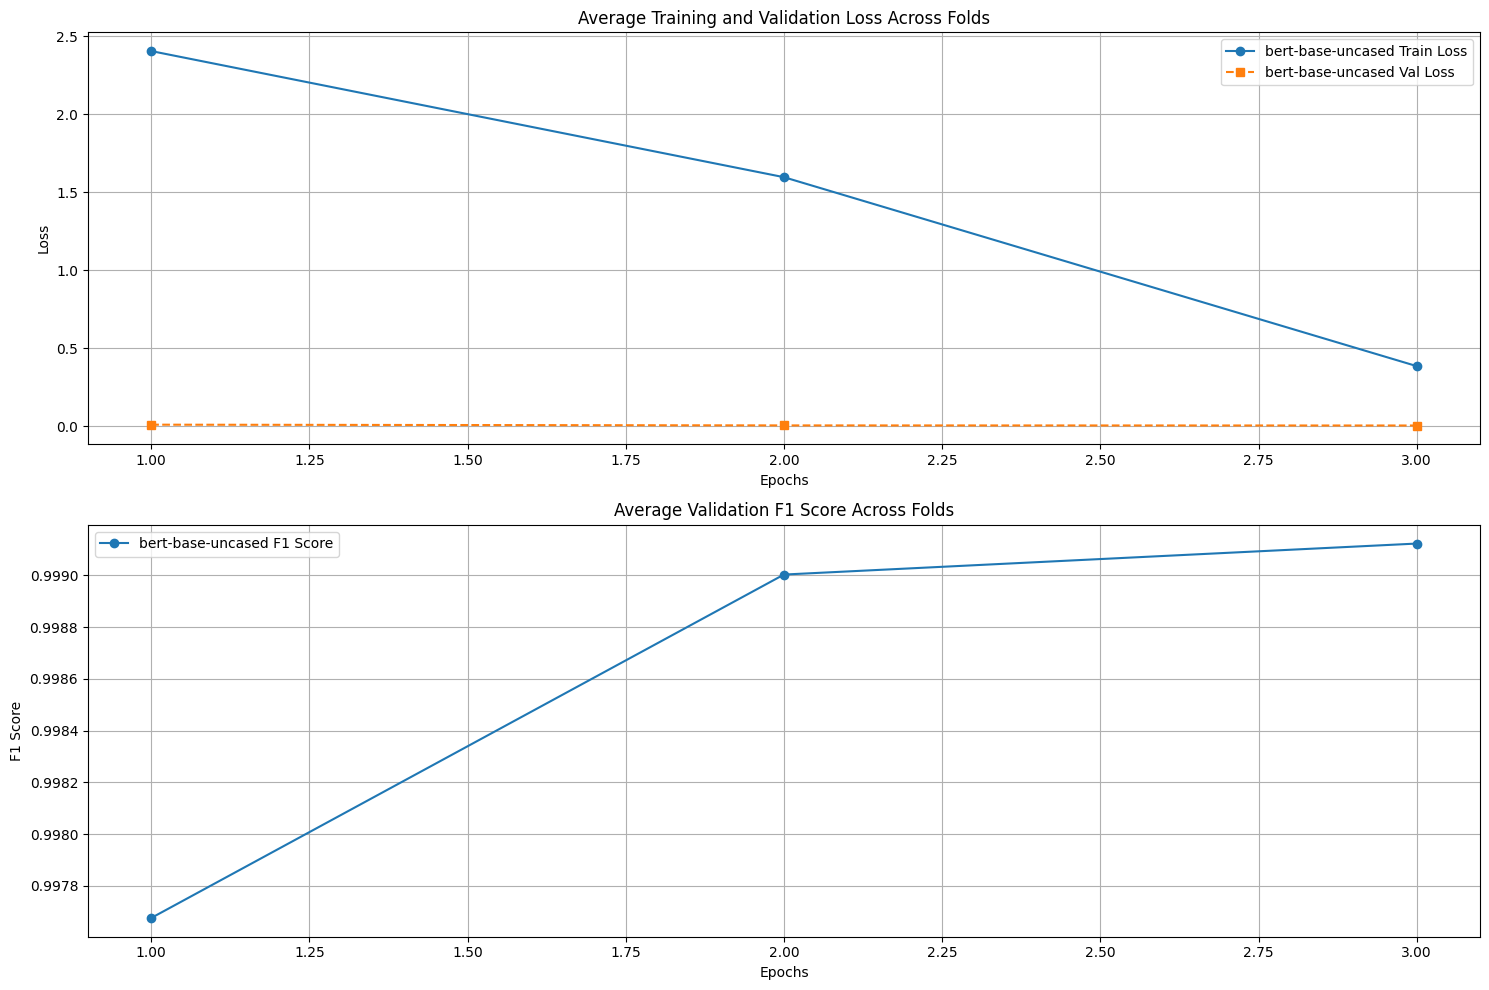

In [9]:
cfg = ConfigCreator(model_name=models[0], lr = lr[0], sl = sl[1], frac = frac[0], bs = bs[1], dataset = dataset[1]).get_config()
metrics = run_cross_validation(cfg)